In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
random_state = 42

### 

In [2]:
train_df = pd.read_csv('train.csv', index_col='id')
holiday_df = pd.read_csv("holidays_events.csv")
transaction_df = pd.read_csv("transactions.csv")
store_df = pd.read_csv('stores.csv')
oil_df = pd.read_csv('oil.csv')

In [3]:
test_df = pd.read_csv('test.csv', index_col='id')

In [4]:
train_df.head(10)

,date,store_nbr,family,sales,onpromotion
id,,,,,
0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,2013-01-01,1,BABY CARE,0.0,0
2,2013-01-01,1,BEAUTY,0.0,0
3,2013-01-01,1,BEVERAGES,0.0,0
4,2013-01-01,1,BOOKS,0.0,0
5,2013-01-01,1,BREAD/BAKERY,0.0,0
6,2013-01-01,1,CELEBRATION,0.0,0
7,2013-01-01,1,CLEANING,0.0,0
8,2013-01-01,1,DAIRY,0.0,0


In [5]:
def transform_date(date):
    # change from "MM/DD/YYYY" -> "YYYY-MM-DD"
    tmp = date.split('/')
    month, day, year = tmp[0], tmp[1], tmp[2]
    if (len(month) == 1): 
        month = '0' + month
    if (len(day) == 1): 
        day = '0' + day
    return "-".join([year, month, day])
holiday_df['date'] = holiday_df['date'].apply(transform_date)

In [6]:
# main dataframe (train_df or test_df) merged with holiday_df
mh_df = train_df.merge(holiday_df, how='left', left_on = 'date', right_on = 'date')
mh_df = mh_df.fillna("None")
mh_df.head(3)

,date,store_nbr,family,sales,onpromotion,type,locale,locale_name,description,transferred
0,2013-01-01,1,AUTOMOTIVE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False
1,2013-01-01,1,BABY CARE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False
2,2013-01-01,1,BEAUTY,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False


In [7]:
# contain: merge of train, holiday and store 
mhs_df = mh_df.merge(store_df, how='left', left_on = 'store_nbr', right_on = 'store_nbr')
mhs_df.head(4)

,date,store_nbr,family,sales,onpromotion,type_x,locale,locale_name,description,transferred,city,state,type_y,cluster
0,2013-01-01,1,AUTOMOTIVE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13
1,2013-01-01,1,BABY CARE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13
2,2013-01-01,1,BEAUTY,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13
3,2013-01-01,1,BEVERAGES,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13


In [8]:
a = np.ones(2)
b = np.zeros(3)
np.concatenate([a, b])

array([1., 1., 0., 0., 0.])

In [8]:
oil_df.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [9]:
pd.isna(oil_df['dcoilwtico']).sum()

43

In [10]:
# handle missing value in oil dataframe
n = len(oil_df)
for i in range(n):
    if (pd.isna(oil_df.iloc[i, 1])):
        if (i - 1 < 0):
            v = oil_df.iloc[i + 1, 1] # chưa chặt lắm
        else:
            v = oil_df.iloc[i - 1, 1]
        oil_df.iloc[i, 1] = v

In [32]:
mhso_df = mhs_df.merge(oil_df, how='left', left_on = 'date', right_on = 'date')
mhso_df.head(5)

,date,store_nbr,family,sales,onpromotion,type_x,locale,locale_name,description,transferred,city,state,type_y,cluster,dcoilwtico
0,2013-01-01,1,AUTOMOTIVE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13,93.14
1,2013-01-01,1,BABY CARE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13,93.14
2,2013-01-01,1,BEAUTY,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13,93.14
3,2013-01-01,1,BEVERAGES,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13,93.14
4,2013-01-01,1,BOOKS,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13,93.14


In [38]:
# handle missing value in oil dataframe
n = len(mhso_df['dcoilwtico'])
arr = mhso_df['dcoilwtico'].values
for i in range(n):
    if (np.isnan(arr[i])):
        if (i - 1 < 0):
            print(i)
            v = arr[i + 1] # chưa chặt lắm
        else:
            v = arr[i - 1]
        arr[i] = v
mhso_df['dcoilwtico'] = arr

In [39]:
oil_price = mhso_df['dcoilwtico'].values.reshape(-1, 1)
np.isnan(oil_price).sum()

0

In [40]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
class FeatureEncoder(object):
    """
        Thực hiện:
         - chuyển family, store_nbr -> one-hot
         - chuyển date -> tập one-hot của dayOfWeek & của month
         - normalize onPromotion
    """
    def __init__(self, X_df):
        weekday = pd.to_datetime(X_df['date']).dt.dayofweek.values.reshape(-1,1)
        month = pd.to_datetime(X_df['date']).dt.month.values.reshape(-1,1)
        self.family_encoder = OneHotEncoder().fit(X_df[['family']])
        self.store_type_encoder = OneHotEncoder().fit(X_df[['type_y']])
        self.week_encoder = OneHotEncoder().fit(weekday)
        self.month_encoder = OneHotEncoder().fit(month)
        self.holiday_type_encoder = OneHotEncoder().fit(X_df[['type_x']])
        self.locale_name_encoder = OneHotEncoder().fit(X_df[['locale_name']])
        self.cluster_encoder = OneHotEncoder().fit(X_df[['cluster']])
        self.city_encoder = OneHotEncoder().fit(X_df[['city']])
    
    def date2feature(self, date_col):
        weekday = pd.to_datetime(date_col).dt.dayofweek.values.reshape(-1,1)
        month = pd.to_datetime(date_col).dt.month.values.reshape(-1,1)
        year = pd.to_datetime(date_col).dt.year.values.reshape(-1,1)
        weekday_features = self.week_encoder.transform(weekday).todense()
        month_features = self.month_encoder.transform(month).todense()
        return np.hstack([year, month_features, weekday_features])

    def preprocess(self, mhso_df):
        date_features = self.date2feature(mhso_df['date'])
        family_features = self.family_encoder.transform(mhso_df[['family']]).todense()
        onpromotion = mhso_df['onpromotion'].values.reshape(-1, 1)
        holiday_type_features = self.holiday_type_encoder.transform(mhso_df[['type_x']]).todense()
        locale_name_features = self.locale_name_encoder.transform(mhso_df[['locale_name']]).todense()
        store_type_features = self.store_type_encoder.transform(mhso_df[['type_y']]).todense()
        cluster_features = self.cluster_encoder.transform(mhso_df[['cluster']]).todense()
        city_features = self.city_encoder.transform(mhso_df[['city']]).todense()
        oil_price = mhso_df['dcoilwtico'].values.reshape(-1, 1)
#         return date_features, family_features, onpromotion, holiday_type_features, locale_name_features, store_type_features, cluster_features, city_features
        X = np.hstack([date_features, family_features, onpromotion, holiday_type_features, locale_name_features, store_type_features, cluster_features, city_features, oil_price])
        return X
encoder = FeatureEncoder(mhso_df)
X = encoder.preprocess(mhso_df)
y = mhso_df['sales'].values
print(X.shape, y.shape)

(3054348, 131) (3054348,)


In [31]:
# from sklearn.linear_model import LinearRegression, Ridge
# from sklearn.ensemble import AdaBoostRegressor
# from sklearn.model_selection import train_test_split
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = random_state)

In [41]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators = 10)
model.fit(X, y)

C:\Users\thamnt36\Anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


RandomForestRegressor(n_estimators=10)

In [43]:
test_df = pd.read_csv('test.csv', index_col='id')
test_mh_df = test_df.merge(holiday_df, how='left', left_on = 'date', right_on = 'date')
test_mh_df = test_mh_df.fillna("None")
test_mhs_df = test_mh_df.merge(store_df, how='left', left_on = 'store_nbr', right_on = 'store_nbr')
test_mhso_df = test_mhs_df.merge(oil_df, how='left', left_on = 'date', right_on = 'date')

# handle missing value in oil dataframe
n = len(test_mhso_df['dcoilwtico'])
arr = test_mhso_df['dcoilwtico'].values
for i in range(n):
    if (np.isnan(arr[i])):
        if (i - 1 < 0):
            print(i)
            v = arr[i + 1] # chưa chặt lắm
        else:
            v = arr[i - 1]
        arr[i] = v
test_mhso_df['dcoilwtico'] = arr

X_test= encoder.preprocess(test_mhso_df)
y_pred = model.predict(X_test)
y_pred = np.where(y_pred > 0, y_pred, 0)
submit = pd.DataFrame(np.hstack([test_df.index.values.reshape(-1, 1), y_pred.reshape(-1, 1)]), columns = ['id', 'sales'])
submit.id = submit.id.astype(np.int32)
submit.to_csv('submit.csv', index=False)

C:\Users\thamnt36\Anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
class FeatureEncoder2(object):
    """
        Thực hiện:
         - chuyển family, store_nbr -> one-hot
         - chuyển date -> tập one-hot của dayOfWeek & của month
         - normalize onPromotion
    """
    def __init__(self, X_df):
        weekday = pd.to_datetime(X_df['date']).dt.dayofweek.values.reshape(-1,1)
        month = pd.to_datetime(X_df['date']).dt.month.values.reshape(-1,1)
        self.family_encoder = OneHotEncoder().fit(X_df[['family']])
        self.store_type_encoder = OneHotEncoder().fit(X_df[['type_y']])
        self.week_encoder = OneHotEncoder().fit(weekday)
        self.month_encoder = OneHotEncoder().fit(month)
        self.holiday_type_encoder = OneHotEncoder().fit(X_df[['type_x']])
        self.locale_name_encoder = OneHotEncoder().fit(X_df[['locale_name']])
        self.cluster_encoder = OneHotEncoder().fit(X_df[['cluster']])
        self.city_encoder = OneHotEncoder().fit(X_df[['city']])
    
    def date2feature(self, date_col):
        weekday = pd.to_datetime(date_col).dt.dayofweek.values.reshape(-1,1)
        month = pd.to_datetime(date_col).dt.month.values.reshape(-1,1)
        year = pd.to_datetime(date_col).dt.year.values.reshape(-1,1) # linear correalation
        weekday_features = self.week_encoder.transform(weekday).todense()
        month_features = self.month_encoder.transform(month).todense()
        return np.hstack([year, month_features, weekday_features])

    def preprocess(self, mh_df):
        date_features = self.date2feature(mh_df['date'])
        family_features = self.family_encoder.transform(mh_df[['family']]).todense()
        onpromotion = mh_df['onpromotion'].values.reshape(-1, 1) # linear correalation
        holiday_type_features = self.holiday_type_encoder.transform(mh_df[['type_x']]).todense()
        locale_name_features = self.locale_name_encoder.transform(mh_df[['locale_name']]).todense()
        store_type_features = self.store_type_encoder.transform(mh_df[['type_y']]).todense()
        cluster_features = self.cluster_encoder.transform(mh_df[['cluster']]).todense()
        city_features = self.city_encoder.transform(mh_df[['city']]).todense()
#         return date_features, family_features, onpromotion, holiday_type_features, locale_name_features, store_type_features, cluster_features, city_features
        X = np.hstack([date_features, family_features, onpromotion, holiday_type_features, locale_name_features, store_type_features, cluster_features, city_features])
        return X
encoder = FeatureEncoder(mhso_df)
X = encoder.preprocess(mhso_df)
y = mhso_df['sales'].values
print(X.shape, y.shape)

In [3]:
import numpy as np
x = np.random.rand(10000)
y = x*2 + 4

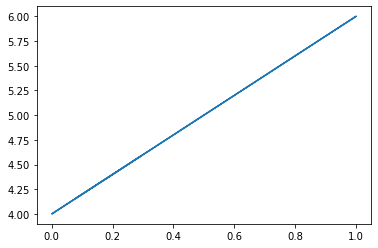

In [4]:
import matplotlib.pyplot as plt
plt.plot(x, y)

(array([1013., 1038., 1025.,  983.,  966.,  946., 1010.,  996., 1029.,
         994.]),
 array([4.00063244, 4.20056731, 4.40050218, 4.60043705, 4.80037192,
        5.00030679, 5.20024166, 5.40017652, 5.60011139, 5.80004626,
        5.99998113]),
 <BarContainer object of 10 artists>)

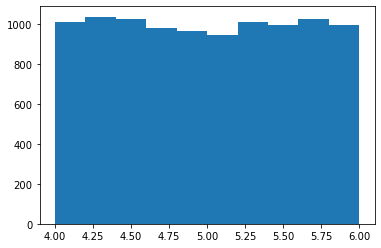

In [5]:
plt.hist(y)